# Running Through and Visualizing Every Part
Trying to figure out why this method is not working properly by plotting the results at each stop

In [21]:
# Append experiment and source directories to system path because jupyter notebook ignores PYTHONPATH
import sys
sys.path.append('../experiments')
sys.path.append('../src')

In [22]:
# Optimization Code
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Callable, Literal
from pathlib import Path
import matplotlib.pyplot as plt
from joint_tof_opt import get_named_moment_module

tof_dataset_path = Path("../data/generated_tof_set_experiment_0000.npz")
measurand = "abs"
harmonic_count = 2
fhr_hw = 0.1
normalize_window = True

## Data Loading
data = np.load(tof_dataset_path)

tof_series = data["tof_dataset"]  # Shape: (num_timepoints, num_bins)
bin_edges = data["bin_edges"]  # Shape: (num_bins + 1,)
sampling_rate = data["sampling_rate"]  # Sampling rate in Hz
fetal_f = data["fetal_f"]  # Fetal heartbeat frequency in Hz
maternal_f = data["maternal_f"]  # Maternal heartbeat frequency in Hz
time_axis = data["time_axis"]  # Time axis
tof_series_tensor = torch.tensor(tof_series, dtype=torch.float32)
bin_edges_tensor = torch.tensor(bin_edges, dtype=torch.float32)
num_timepoints, num_bins = tof_series_tensor.shape
if isinstance(measurand, str):
    moment_calculator = get_named_moment_module(measurand, tof_series_tensor, bin_edges_tensor)
else:
    moment_calculator = measurand

fetal_bin = int(fetal_f / (sampling_rate / 2 / num_timepoints))
maternal_bin = int(maternal_f / (sampling_rate / 2 / num_timepoints))
fetal_bins = []
for h in range(1, harmonic_count + 1):
    width_int_in_bins = int(fhr_hw / (sampling_rate / 2 / num_timepoints))
    left_edge = max(fetal_bin - h * width_int_in_bins, 0)
    right_edge = min(fetal_bin + h * width_int_in_bins, num_timepoints // 2)
    fetal_bins.extend(list(range(left_edge, right_edge + 1)))

# Step 1: Find bmax
average_dtof = torch.mean(tof_series_tensor, dim=0)  # Shape: (num_bins,)
bmax = int(torch.argmax(average_dtof).item())

# Step 2: Find b0 (first bin to the right of bmax with ~50% of bmax count assuming a falling edge)
half_max_value = average_dtof[bmax] * 0.5
b0 = bmax  # 50% point bin
for b in range(bmax + 1, num_bins):
    if average_dtof[b] <= half_max_value:
        b0 = b
        break
bf = num_bins - 1 # bin where counts fall to 10% of max
# for b in range(num_bins - 1, bmax, -1):
#     if average_dtof[b] <= half_max_value * 0.1:
#         bf = b
#         break

# Step 3: Nested loop over (b2, b3)
measurand_fft_dict = {}
noise_floor_dict = {}
fetal_fft_component_dict = {}
snr_dict = {}

best_snr = 0.0
best_window = None
for b2 in range(bmax, bf):
# for b2 in range(b0, bf):
    for b3 in range(b2, bf):    # Inclusive
        # Create rectangular window
        window = torch.zeros(num_bins, dtype=torch.float32)
        window[b2 : b3 + 1] = 1.0
        window /= torch.norm(window, 2)  # Normalize window
        measurand_series = moment_calculator(window)
        measurand_series = measurand_series - torch.mean(measurand_series)  # Detrend
        measurand_fft = torch.fft.rfft(measurand_series)
        fetal_fft_component = float(measurand_fft[fetal_bins].abs().sum().item())
        # Compute noise floor using MAD
        # measurand_fft_without_excluded = measurand_fft[bins_to_include]
        measurand_fft_without_excluded = measurand_fft
        median_fft = torch.median(measurand_fft_without_excluded.abs()).item()
        mad_fft = torch.median(torch.abs(measurand_fft_without_excluded.abs() - median_fft)).item()
        noise_floor = mad_fft * 1.4826  # Convert MAD to std dev
        if noise_floor == 0:
            continue
        snr = fetal_fft_component / noise_floor
        if snr > best_snr:
            best_snr = snr
            best_window = window.clone()  # Clone this so we don't point to the changing tensor
        
        # Logging for analysis
        measurand_fft_dict[(b2, b3)] = measurand_fft.clone()
        noise_floor_dict[(b2, b3)] = noise_floor
        fetal_fft_component_dict[(b2, b3)] = fetal_fft_component
        snr_dict[(b2, b3)] = snr

# Prepare Output
if best_window is not None:
    if normalize_window:
        best_window = best_window / torch.norm(best_window)
else:
    raise ValueError("Something went wrong with Liu optimization; no valid window that improves SNR above 0.")


print("Optimized Window:", best_window.numpy())

Optimized Window: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


# Visuailizations

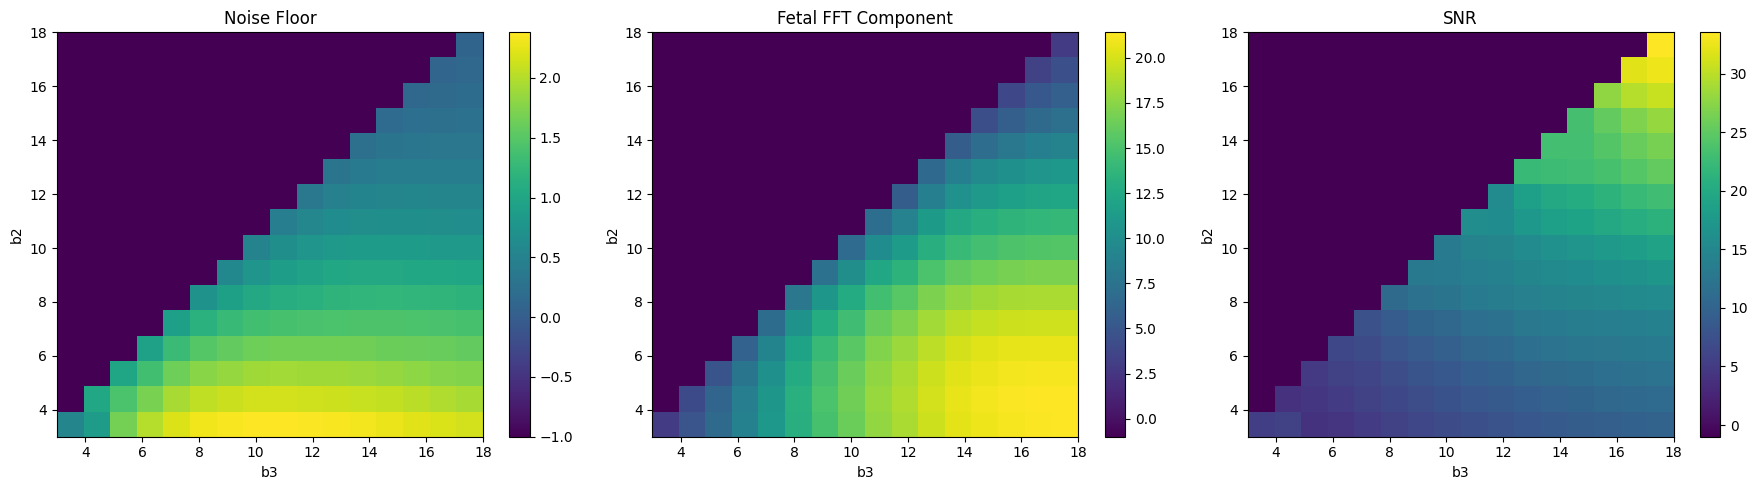

In [23]:
# Create figure with subplots for the three metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Extract coordinates and create 2D grids
coords = list(snr_dict.keys())
b2_vals = sorted(set([c[0] for c in coords]))
b3_vals = sorted(set([c[1] for c in coords]))

# Function to fill grids from dictionaries
def fill_grids(b2_vals, b3_vals, *dicts):
    """Fill grids from dictionaries with (b2, b3) keys."""
    grids = []
    for d in dicts:
        grid = np.full((len(b2_vals), len(b3_vals)), -1.0)
        for (b2, b3), value in d.items():
            i = b2_vals.index(b2)
            j = b3_vals.index(b3)
            grid[i, j] = value
        grids.append(grid)
    return grids

# Fill in the grids using the function
noise_floor_grid, fetal_fft_grid, snr_grid = fill_grids(
    b2_vals, b3_vals, 
    noise_floor_dict, 
    fetal_fft_component_dict, 
    snr_dict
)
grids = [noise_floor_grid, fetal_fft_grid, snr_grid]
titles = ['Noise Floor', 'Fetal FFT Component', 'SNR']
for ax, grid, title in zip(axes, grids, titles):
    im = ax.imshow(grid, aspect='auto', origin='lower', extent=[b3_vals[0], b3_vals[-1], b2_vals[0], b2_vals[-1]])
    ax.set_xlabel('b3')
    ax.set_ylabel('b2')
    ax.set_title(title)
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()